In [1]:
import hdf5storage as hdf
import tensorflow as tf
import test_model as tm
import numpy as np
import math 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = []
for i in range(100):
    loc = i+1
    filepath = '/home/charlieniu21/code/Deep-ADMM-Net/data/ChestTrain/im-'
    if loc < 10 :
        fp = filepath+'0'+str(loc)+'.mat'
    else:
        fp = filepath+str(loc)+'.mat'
    d = hdf.loadmat(fp)
    d_true = np.array(d['im_ori'])
    data.append(d_true)

In [3]:
mask = hdf.loadmat('/home/charlieniu21/code/Deep-ADMM-Net/mask/mask_10.mat')
mask = np.array(mask['mask'])
mask = np.fft.ifftshift(mask)
mask = np.reshape(mask, [1, 256, 256])

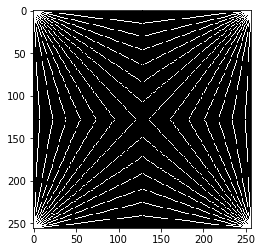

In [4]:
plt.imshow(np.reshape(mask,[256, 256]), cmap = "gray")

In [5]:
data = np.array(data)
data = np.reshape(data, [100, 256, 256, 1])

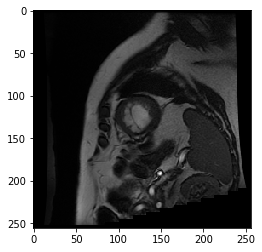

In [6]:
plt.imshow(np.reshape(data[10,:,:,:], [256, 256]), cmap = "gray")

In [7]:
def get_batch(size = 20):
    batch_loc = np.random.randint(100, size = size)
    return data[batch_loc, :, :, :]

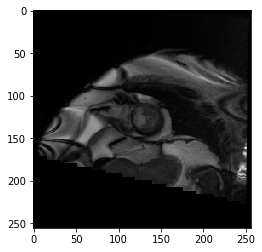

In [8]:
b1 = get_batch()
plt.imshow(np.reshape(b1[14,:,:,:], [256, 256]), cmap = "gray")

In [9]:
def get_masked(data, mask):
    d_complex = tf.reshape(tf.cast(data, tf.complex64),
                           [data.shape[0], 256, 256])
    mask_complex = tf.cast(mask, tf.complex64)
    d_kspace = tf.fft2d(d_complex)*mask_complex
    d_masked_complex = tf.ifft2d(d_kspace)
    d_masked_real = tf.reshape(tf.real(d_masked_complex), 
                               [d_masked_complex.get_shape()[0], 256, 256, 1])
    d_masked_imag = tf.reshape(tf.imag(d_masked_complex), 
                               [d_masked_complex.get_shape()[0], 256, 256, 1])
    d_masked = tf.concat([d_masked_real, d_masked_imag], axis = 3)
    with tf.Session() as sess:
        masked = sess.run(d_masked)
    return masked

In [10]:
masked = get_masked(b1, mask)

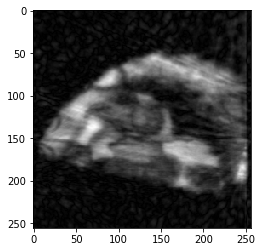

In [11]:
m1 = tf.cast(masked[14][:][:][:], tf.complex64)
re = m1[:,:,0]+1j*m1[:,:,1]
r = tf.abs(re)
r = tf.reshape(r, [256, 256])
with tf.Session() as sess:
    o1 = sess.run(r)
plt.imshow(o1, cmap = "gray")

In [12]:
batchsize = 20 # change it along with test_model.py
model_input_masked = tf.placeholder(tf.float32, [batchsize, 256, 256, 2], 
                                    "masked")
model_input_gtrue = tf.placeholder(tf.float32, [batchsize, 256, 256, 1], 
                                   "ground_truth")


In [13]:
gene_output, gene_output_complex, gene_output_list, gene_var_list, gene_layers, disc_real_output, disc_fake_output, disc_var_list, disc_layers = tm.create_model(model_input_masked, model_input_gtrue, mask)
    
    
gene_loss, gene_dc_loss, gene_fool_loss, list_gene_lose, gene_mse_factor = tm.create_generator_loss(disc_fake_output, gene_output, gene_output_complex, gene_output_list, model_input_masked, model_input_gtrue, mask)
    
    
disc_loss = tm.create_discriminator_loss(disc_real_output, disc_fake_output)
    
global_step, learning_rate, gene_minimize, disc_minimize = tm.create_optimizers(gene_loss, gene_var_list,disc_loss, disc_var_list)

use resnet without pooling: [128, 128, 128, 128, 128]
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 256, 2), output dim (20, 256, 256)
using Fourier, input dim (20, 256, 2

In [17]:
import time

def train_process(epochs = 20, batch_size = 20):
    gene_train_log = []
    disc_train_log = []
    train_time = 0
    while train_time<epochs:
        start_time = time.time()
        batch_true = get_batch(batch_size)
        batch_masked = get_masked(batch_true, mask)
        g_los, d_los = sess.run([gene_loss, disc_loss],feed_dict = {model_input_masked:batch_masked, model_input_gtrue:batch_true, learning_rate: 0.01})
        #print('done with loss')
        gene_train_log.append(g_los)
        disc_train_log.append(d_los)
        sess.run([gene_minimize,disc_minimize],feed_dict = {model_input_masked:batch_masked, model_input_gtrue:batch_true, learning_rate: 0.01})
        print("epoch: "+str(train_time)+", g_loss: "+str(g_los)+", d_loss: "+str(d_los)+" time_spent:"+str(time.time()-start_time)+"s")
        train_time += 1
    return (gene_train_log, disc_train_log)

In [15]:
sess = tf.Session()
init = tf.global_variables_initializer()
writer = tf.summary.FileWriter("logs/", sess.graph)
sess.run(init)

In [18]:
g_log, d_log = train_process(epochs = 5)

epoch: 0, g_loss: 48.66168, d_loss: 0.559026 time_spent:135.67337489128113s
epoch: 1, g_loss: 406464350.0, d_loss: 0.7580456 time_spent:108.22951865196228s
epoch: 2, g_loss: 9480784.0, d_loss: 0.59124017 time_spent:108.69181108474731s
epoch: 3, g_loss: 162303.8, d_loss: 0.5626519 time_spent:108.63432002067566s
epoch: 4, g_loss: 46365.176, d_loss: 0.52084845 time_spent:109.58008170127869s
